In [1]:
# pyright: reportAttributeAccessIssue=false, reportArgumentType=false, reportOperatorIssue=false
from pathlib import Path
import pandas as pd
import geopandas as gpd

ROOT: Path = Path.cwd()
if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
    ROOT = ROOT.parent


In [2]:
# --- Recreate ROOT and helper imports ---
from pathlib import Path
import geopandas as gpd

ROOT = Path.cwd()
if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
    ROOT = ROOT.parent

print("Project root:", ROOT)


Project root: /Users/warrenjones/Dev/igs-analysis-baltimore


In [3]:
# === Setup (run once at the top) ===
from pathlib import Path
import sys

# Resolve project root whether you opened the notebook from repo root or /notebooks
ROOT = Path.cwd()
if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))  # so local modules are importable

# Try to import your project helpers; otherwise provide minimal fallbacks
try:
    from build_points_features import load_points_any, points_to_tract_counts, save_feat
except Exception:
    import geopandas as gpd
    from shapely.geometry import Point
    import pandas as pd

    def load_points_any(fp):
        gdf = gpd.read_file(fp)
        if gdf.crs is None:
            gdf.set_crs("EPSG:4326", inplace=True)
        return gdf

    def points_to_tract_counts(points_gdf,
                               tracts_fp=ROOT / "data_raw" / "shapes" / "2020_Census_Tracts_(Census_TIGER).geojson",
                               tract_id_col="GEOID"):
        tracts = gpd.read_file(tracts_fp)
        if tracts.crs is None:
            tracts.set_crs("EPSG:4326", inplace=True)
        if points_gdf.crs != tracts.crs:
            points_gdf = points_gdf.to_crs(tracts.crs)

        joined = gpd.sjoin(points_gdf,
                           tracts[[tract_id_col, "geometry"]],
                           how="inner", predicate="within")
        counts = (joined.groupby(tract_id_col)
                        .size()
                        .rename("count")
                        .reset_index())
        return counts

    def save_feat(df, name):
        out = ROOT / "data_clean" / name
        out.parent.mkdir(parents=True, exist_ok=True)
        if name.endswith(".parquet"):
            try:
                df.to_parquet(out, index=False)
            except Exception:
                # fallback if pyarrow/fastparquet isn't installed
                out = out.with_suffix(".csv")
                df.to_csv(out, index=False)
        else:
            df.to_csv(out, index=False)
        print(f"Saved → {out}")


In [4]:
import geopandas as gpd

tracts_fp = ROOT / "data_raw" / "shapes" / "2020_Census_Tracts_(Census_TIGER).geojson"
tracts = gpd.read_file(tracts_fp)
tracts.columns.tolist(), tracts.head(1)


(['OBJECTID',
  'STATEFP20',
  'COUNTYFP20',
  'TRACTCE20',
  'GEOID20',
  'NAME20',
  'NAMELSAD20',
  'MTFCC20',
  'FUNCSTAT20',
  'ALAND20',
  'AWATER20',
  'INTPTLAT20',
  'INTPTLON20',
  'Shape_Length',
  'Shape_Area',
  'geometry'],
    OBJECTID STATEFP20 COUNTYFP20 TRACTCE20      GEOID20   NAME20  \
 0         1        24        003    731103  24003731103  7311.03   
 
      NAMELSAD20 MTFCC20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
 0  Census Tract   G5020          S  8562084         0  +39.0343178   
 
      INTPTLON20  Shape_Length    Shape_Area  \
 0  -076.4946333  51684.935897  9.215257e+07   
 
                                             geometry  
 0  POLYGON ((-76.52241 39.05171, -76.52232 39.051...  )

In [5]:
# Step 2a — Schools
schools_fp = ROOT / "data_raw" / "shapes" / "Baltimore_City_Schools.geojson"
schools = load_points_any(schools_fp)
sch_counts = points_to_tract_counts(schools, tract_id_col="GEOID20")
save_feat(sch_counts, "tract_schools_count.parquet")



Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_schools_count.parquet


## Step 2b – Batch tract counts for all point datasets


In [6]:
point_layers = {
    "Baltimore_City_Schools.geojson":        "tract_schools_count.parquet",
    "Farmers_Market.geojson":                 "tract_farmers_markets_count.parquet",
    "Library_-4027963679923662099.geojson":   "tract_libraries_count.parquet",
    "Liquor_Licenses.geojson":                "tract_liquor_licenses_count.parquet",
    "Restaurants.geojson":                    "tract_restaurants_count.parquet",
    "Environmental_Citations.geojson":        "tract_env_citations_count.parquet",
    "Number_of_Banks_and_Bank_Branches_per_1,000_Residents.geojson": "tract_banks_count.parquet",
    "Vacant_Building_Notices.geojson":        "tract_vacant_notices_count.parquet",
    "Vacant_Building_Rehabs.geojson":         "tract_vacant_rehabs_count.parquet",
    "Real_Property_Information.geojson":      "tract_real_property_count.parquet",
}

processed = []
for fname, outname in point_layers.items():
    fp = ROOT / "data_raw" / "shapes" / fname
    try:
        gdf = load_points_any(fp)
        # guard: if this is actually polygons/lines, skip (counting points only)
        if gdf.geometry.iloc[0].geom_type not in {"Point", "MultiPoint"}:
            print(f"Skipped (not points): {fname}")
            continue
        counts = points_to_tract_counts(gdf, tract_id_col="GEOID20")
        save_feat(counts, outname)
        processed.append(outname)
    except Exception as e:
        print(f"FAILED {fname} → {e}")

processed


Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_schools_count.parquet
Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_farmers_markets_count.parquet
Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_libraries_count.parquet
FAILED Liquor_Licenses.geojson → 'NoneType' object has no attribute 'geom_type'
Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_restaurants_count.parquet
FAILED Environmental_Citations.geojson → 'NoneType' object has no attribute 'geom_type'
Skipped (not points): Number_of_Banks_and_Bank_Branches_per_1,000_Residents.geojson
Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_vacant_notices_count.parquet
Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_vacant_rehabs_count.parquet
Skipped (not points): Real_Property_Information.geojson


['tract_schools_count.parquet',
 'tract_farmers_markets_count.parquet',
 'tract_libraries_count.parquet',
 'tract_restaurants_count.parquet',
 'tract_vacant_notices_count.parquet',
 'tract_vacant_rehabs_count.parquet']

In [7]:
import geopandas as gpd

liquor_fp = ROOT / "data_raw" / "shapes" / "Liquor_Licenses.geojson"
liquor = gpd.read_file(liquor_fp)

# View basic info
liquor.info()
liquor.head(3)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30284 entries, 0 to 30283
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   LLKey              30284 non-null  int32              
 1   CorpKey            30284 non-null  int32              
 2   LicenseClass       30284 non-null  object             
 3   SubClass           30284 non-null  object             
 4   LicenseNumber      30284 non-null  object             
 5   LicenseDate        30284 non-null  datetime64[ms, UTC]
 6   LicenseEndDate     30284 non-null  datetime64[ms, UTC]
 7   LicenseYear        30284 non-null  int32              
 8   LicenseFee         30284 non-null  float64            
 9   CertificateNumber  30283 non-null  object             
 10  LicenseStatus      29961 non-null  object             
 11  LicenseeFirstName  30284 non-null  object             
 12  LicenseeLastName   30284 non-null  obj

,LLKey,CorpKey,LicenseClass,SubClass,LicenseNumber,LicenseDate,LicenseEndDate,LicenseYear,LicenseFee,CertificateNumber,...,LicenseeLastName,TradeName,CorpName,EstablishmentDesc,DayPerWeek,Description,AddrStreet,AddrZip,ESRI_OID,geometry
0,100005,201005,LBD7,BWL,171,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1272,...,MYNAR,RED ROOSTER,"RED ROOSTER, INC.",Tavern,7 days,"Beer, Wine, & Liquor",6412-16 FRANKFORD AVENUE,21206,1,None
1,100005,201005,LBD7,BWL,171,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1272,...,MYNAR,RED ROOSTER,"RED ROOSTER, INC.",Tavern,7 days,"Beer, Wine, & Liquor",6412-16 FRANKFORD AVENUE,21206,2,None
2,100026,201026,LBD7,BWL,403,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1506,...,MARTIN (IND&PR),CLUB CHARLES-ZODIAC,"MARTIN & KAHOE, INC.",Tavern,7 days,"Beer, Wine, & Liquor",1724-26 CHARLES STREET NORTH,21201,3,None


In [8]:
# Check how many rows have missing or invalid geometry
bad_geom = liquor[liquor.geometry.is_empty | liquor.geometry.isna()]
print(f"Missing or empty geometries: {len(bad_geom)} out of {len(liquor)}")

# Peek at one bad record if any
bad_geom.head(3)


Missing or empty geometries: 30284 out of 30284


,LLKey,CorpKey,LicenseClass,SubClass,LicenseNumber,LicenseDate,LicenseEndDate,LicenseYear,LicenseFee,CertificateNumber,...,LicenseeLastName,TradeName,CorpName,EstablishmentDesc,DayPerWeek,Description,AddrStreet,AddrZip,ESRI_OID,geometry
0,100005,201005,LBD7,BWL,171,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1272,...,MYNAR,RED ROOSTER,"RED ROOSTER, INC.",Tavern,7 days,"Beer, Wine, & Liquor",6412-16 FRANKFORD AVENUE,21206,1,None
1,100005,201005,LBD7,BWL,171,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1272,...,MYNAR,RED ROOSTER,"RED ROOSTER, INC.",Tavern,7 days,"Beer, Wine, & Liquor",6412-16 FRANKFORD AVENUE,21206,2,None
2,100026,201026,LBD7,BWL,403,2003-05-01 04:00:00+00:00,2004-04-30 04:00:00+00:00,2003,1320.0,1506,...,MARTIN (IND&PR),CLUB CHARLES-ZODIAC,"MARTIN & KAHOE, INC.",Tavern,7 days,"Beer, Wine, & Liquor",1724-26 CHARLES STREET NORTH,21201,3,None


In [9]:
liquor.columns


Index(['LLKey', 'CorpKey', 'LicenseClass', 'SubClass', 'LicenseNumber',
       'LicenseDate', 'LicenseEndDate', 'LicenseYear', 'LicenseFee',
       'CertificateNumber', 'LicenseStatus', 'LicenseeFirstName',
       'LicenseeLastName', 'TradeName', 'CorpName', 'EstablishmentDesc',
       'DayPerWeek', 'Description', 'AddrStreet', 'AddrZip', 'ESRI_OID',
       'geometry'],
      dtype='object')

In [10]:
import pandas as pd
import geopandas as gpd

liquor_fp = ROOT / "data_raw" / "shapes" / "Liquor_Licenses.geojson"
liquor = gpd.read_file(liquor_fp)

# Minimal address compose; tweak if you have city/state columns
def make_addr(row):
    street = (row.get("AddrStreet") or "").strip()
    zipc   = str(row.get("AddrZip") or "").strip()
    if zipc and not zipc.isdigit():
        zipc = ""  # occasionally junk gets in ZIP
    # Baltimore context helps geocoders
    return ", ".join([p for p in [street, "Baltimore, MD", zipc] if p])

liquor["full_addr"] = liquor.apply(make_addr, axis=1)
liquor = liquor[liquor["full_addr"].str.len() > 0].copy()
len(liquor), liquor["full_addr"].head()


(30284,
 0       6412-16 FRANKFORD AVENUE, Baltimore, MD, 21206
 1       6412-16 FRANKFORD AVENUE, Baltimore, MD, 21206
 2    1724-26 CHARLES STREET NORTH, Baltimore, MD, 2...
 3               1539 BUSH STREET, Baltimore, MD, 21230
 4               1539 BUSH STREET, Baltimore, MD, 21230
 Name: full_addr, dtype: object)

In [11]:
%pip install -q geopy



Note: you may need to restart the kernel to use updated packages.


In [12]:
# --- Revised: safe, cached, resumable geocoding for `liquor` ---
import pandas as pd, geopandas as gpd
from pathlib import Path
from shapely.geometry import Point

cache_dir = ROOT / "data_intermediate"
cache_dir.mkdir(exist_ok=True)
cache_fp  = cache_dir / "liquor_geocoded.parquet"

DO_GEOCODE = False  # ← set to True only when you explicitly want to geocode

def build_gdf_from_latlon(df, lat_col="lat", lon_col="lon", crs="EPSG:4326"):
    df = df.dropna(subset=[lat_col, lon_col]).copy()
    df["geometry"] = [Point(float(x), float(y)) for x, y in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs=crs)

# 1) Use cache if it exists
if cache_fp.exists():
    liquor_ok = gpd.read_parquet(cache_fp)
    print(f"Loaded cached geocoded points → {cache_fp}")

# 2) Geocode only if explicitly enabled
elif DO_GEOCODE:
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter

    if "full_addr" not in liquor.columns:
        raise KeyError("Expected a `full_addr` column on `liquor`.")

    # Prepare columns and resume if partially filled
    if "lat" not in liquor.columns: liquor["lat"] = pd.NA
    if "lon" not in liquor.columns: liquor["lon"] = pd.NA

    geolocator = Nominatim(user_agent="igs-analysis-baltimore")
    geocode = RateLimiter(
        geolocator.geocode,
        min_delay_seconds=1.1,  # respect public rate limits
        error_wait_seconds=5.0,
        max_retries=3,
        swallow_exceptions=True
    )

    # Geocode only rows still missing coordinates
    to_do = liquor[liquor["lat"].isna() | liquor["lon"].isna()].copy()
    print(f"Geocoding {len(to_do)} addresses (skipping already geocoded rows)…")

    for i, (idx, addr) in enumerate(to_do["full_addr"].items(), 1):
        loc = geocode(addr)
        if loc:
            liquor.at[idx, "lat"] = loc.latitude
            liquor.at[idx, "lon"] = loc.longitude

        # lightweight checkpoint every 250 rows
        if i % 250 == 0:
            print(f"  checkpoint @ {i}…")
            tmp_ok = build_gdf_from_latlon(liquor)
            tmp_ok.to_parquet(cache_fp, index=False)

    liquor_ok = build_gdf_from_latlon(liquor)
    liquor_ok.to_parquet(cache_fp, index=False)
    print(f"Saved cache → {cache_fp}  (rows: {len(liquor_ok)})")

# 3) Otherwise, skip cleanly
else:
    liquor_ok = None
    print("Geocoding disabled (DO_GEOCODE=False). Using cache if present; otherwise skipping.")

# Optional: downstream guard
if liquor_ok is not None:
    print(f"Geocoded points ready: {len(liquor_ok)}")
else:
    print("No geocoded liquor points available; downstream steps will be skipped.")



Geocoding disabled (DO_GEOCODE=False). Using cache if present; otherwise skipping.
No geocoded liquor points available; downstream steps will be skipped.


In [13]:
from pathlib import Path

# Define project root directory dynamically
ROOT = Path.cwd()
if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
    ROOT = ROOT.parent

print("Project root:", ROOT)


Project root: /Users/warrenjones/Dev/igs-analysis-baltimore


In [14]:
import pandas as pd
import geopandas as gpd

# Load base tract polygons (for GEOID reference)
tracts = gpd.read_file(ROOT / "data_raw" / "shapes" / "2020_Census_Tracts_(Census_TIGER).geojson")[["GEOID20"]]
tracts = tracts.rename(columns={"GEOID20": "GEOID"}).drop_duplicates()

# Helper to read each tract-level file safely
def read_counts(name, col):
    df = pd.read_parquet(ROOT / "data_clean" / name)
    key = "GEOID20" if "GEOID20" in df.columns else ("GEOID" if "GEOID" in df.columns else None)
    if key is None:
        raise ValueError(f"No GEOID column found in {name}")
    df = df.rename(columns={key: "GEOID", "count": col})
    return df[["GEOID", col]]

# List of files and new column names
joins = [
    ("tract_schools_count.parquet", "cnt_schools"),
    ("tract_farmers_markets_count.parquet", "cnt_fmarkets"),
    ("tract_libraries_count.parquet", "cnt_libraries"),
    ("tract_restaurants_count.parquet", "cnt_restaurants"),
    ("tract_vacant_notices_count.parquet", "cnt_vacant_notices"),
    ("tract_vacant_rehabs_count.parquet", "cnt_vacant_rehabs"),
    # You can add the liquor layer later when it’s ready:
    # ("tract_liquor_licenses_count.parquet", "cnt_liquor")
]

# Merge all features
features = tracts.copy()
for fname, col in joins:
    try:
        df = read_counts(fname, col)
        features = features.merge(df, on="GEOID", how="left")
    except FileNotFoundError:
        print(f"⚠️ Skipped missing file: {fname}")
        continue

# Replace NaNs with 0 (tracts with no points)
features = features.fillna(0)

# Save final wide feature table
out_fp = ROOT / "data_clean" / "tract_features_wide.parquet"
features.to_parquet(out_fp, index=False)

print(f"✅ Saved merged feature table → {out_fp}")
features.head()


✅ Saved merged feature table → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/tract_features_wide.parquet


,GEOID,cnt_schools,cnt_fmarkets,cnt_libraries,cnt_restaurants,cnt_vacant_notices,cnt_vacant_rehabs
0,24003731103,0.0,0.0,0.0,0.0,0.0,0.0
1,24003707001,0.0,0.0,0.0,0.0,0.0,0.0
2,24003740800,0.0,0.0,0.0,0.0,0.0,0.0
3,24003702402,0.0,0.0,0.0,0.0,0.0,0.0
4,24003731303,0.0,0.0,0.0,0.0,0.0,0.0


Will map: ['cnt_schools', 'cnt_fmarkets', 'cnt_libraries', 'cnt_restaurants', 'cnt_vacant_notices', 'cnt_vacant_rehabs']


/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


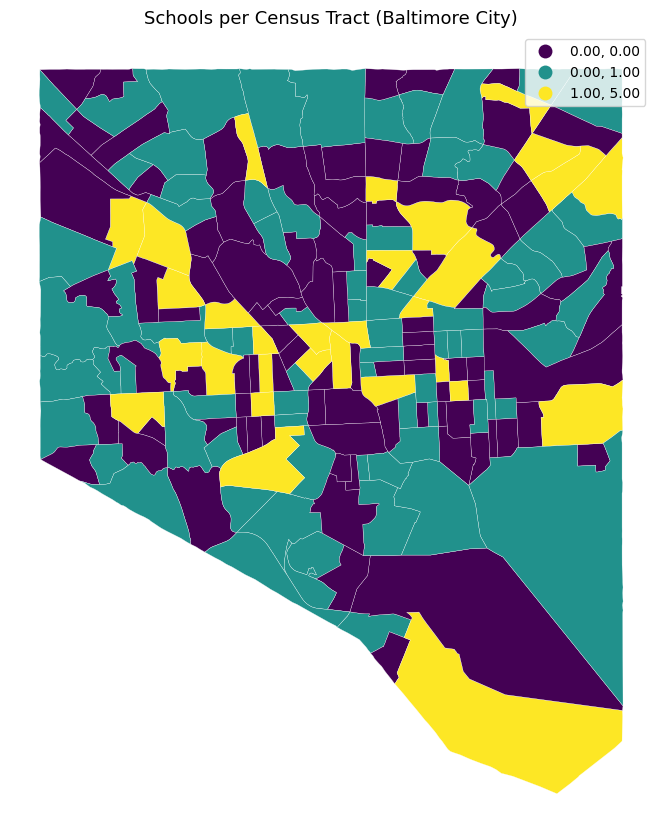

/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_schools.png


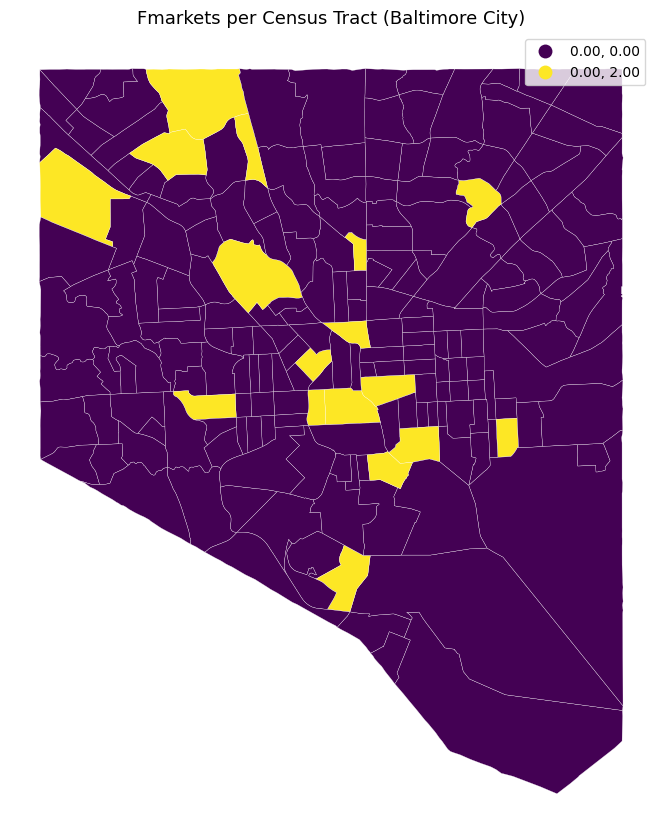

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_fmarkets.png


/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


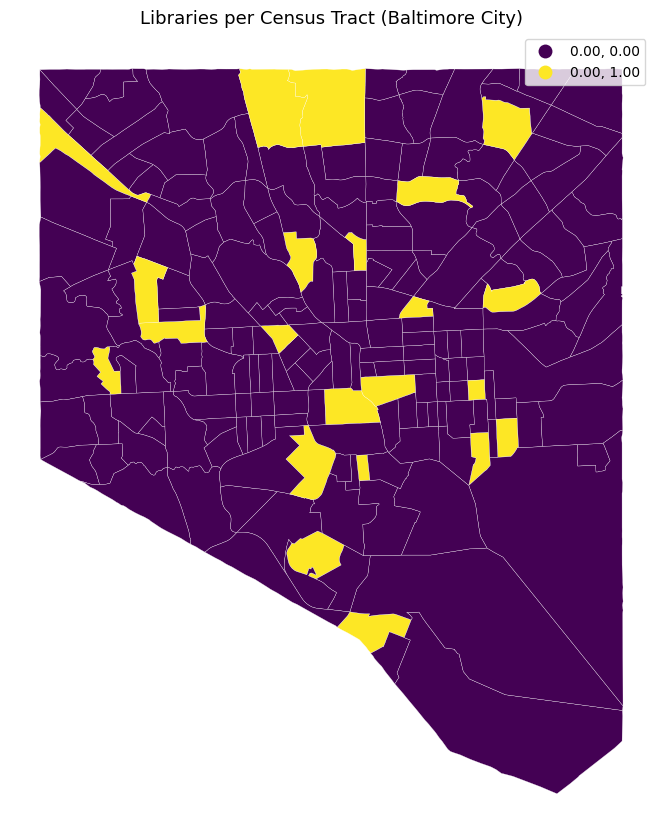

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_libraries.png


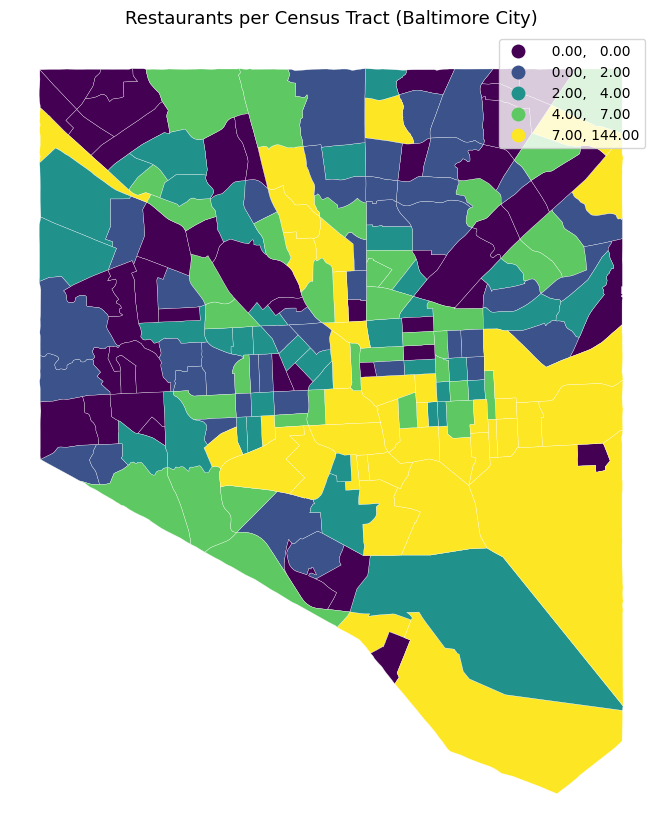

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_restaurants.png


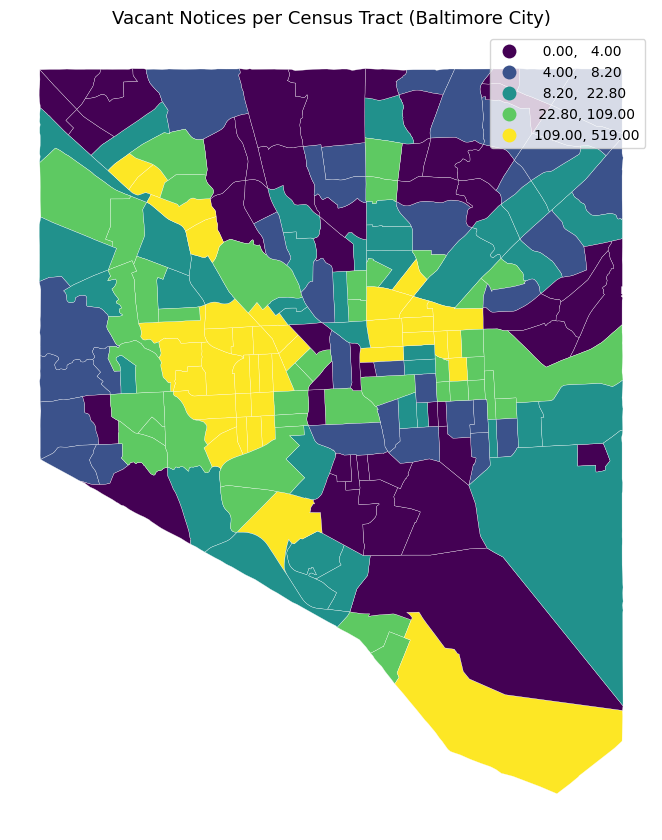

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_vacant_notices.png


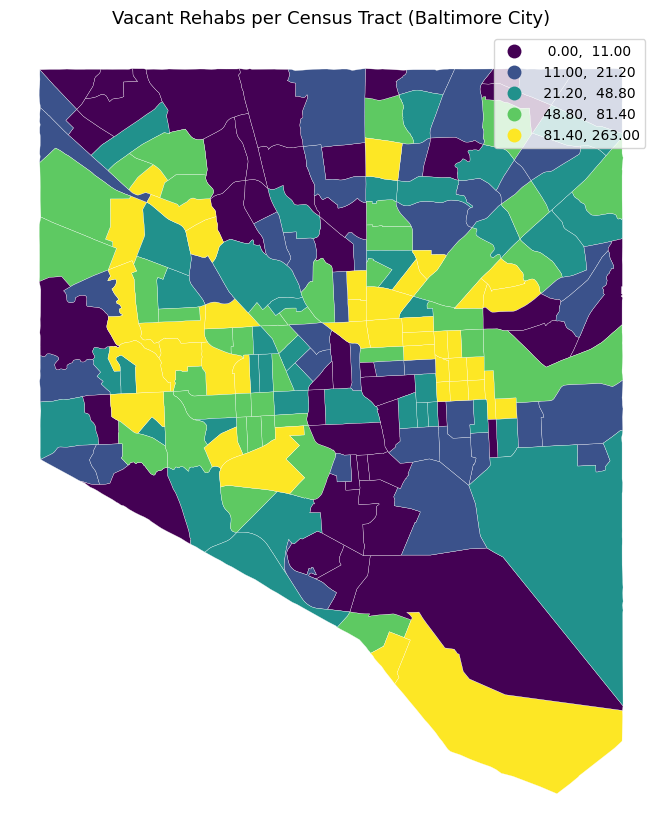

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/cnt_vacant_rehabs.png


In [15]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Geometry: Baltimore City tracts only (MD=24, Baltimore City county FIPS=510) ---
tracts_raw = gpd.read_file(
    ROOT / "data_raw" / "shapes" / "2020_Census_Tracts_(Census_TIGER).geojson"
)[["GEOID20", "COUNTYFP20", "geometry"]]

tracts_city = tracts_raw[tracts_raw["COUNTYFP20"] == "510"].copy()  # Baltimore City
tracts_city = tracts_city.rename(columns={"GEOID20": "GEOID"}).reset_index(drop=True)

# --- Attributes ---
features = pd.read_parquet(ROOT / "data_clean" / "tract_features_wide.parquet")

# --- Merge ---
gdf = tracts_city.merge(features, on="GEOID", how="left").fillna(0)

# --- Which variables to map ---
numeric_cols = [c for c in gdf.columns if c.startswith("cnt_")]
print("Will map:", numeric_cols)

# Ensure output folder
outdir = ROOT / "visuals"
outdir.mkdir(exist_ok=True)

# --- Plot each as a choropleth with quantile bins ---
# If mapclassify is available, geopandas will use it for 'scheme="quantiles"'
for col in numeric_cols:
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    try:
        gdf.plot(column=col, scheme="quantiles", k=5, cmap="viridis",
                 legend=True, linewidth=0.2, edgecolor="white", ax=ax)
    except Exception:
        # Fallback if mapclassify isn't installed: use a robust min/max
        vmin, vmax = gdf[col].quantile([0.05, 0.95])
        gdf.plot(column=col, cmap="viridis", legend=True, vmin=vmin, vmax=vmax,
                 linewidth=0.2, edgecolor="white", ax=ax)
    ax.set_title(f"{col.replace('cnt_', '').replace('_',' ').title()} per Census Tract (Baltimore City)", fontsize=13)
    ax.axis("off")
    plt.tight_layout()
    png = outdir / f"{col}.png"
    plt.savefig(png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved → {png}")


In [20]:
import re, pandas as pd
from pathlib import Path

COMM_DIR = ROOT / "data_raw" / "community"

def _normalize_text(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    target = _normalize_text(substr)
    for p in dirpath.glob("*.csv"):
        if target in _normalize_text(p.name):
            return pd.read_csv(p)
    raise FileNotFoundError(f"No CSV in {dirpath} contains: {substr}")

income    = load_by_substr("Median_Household_Income")
poverty   = load_by_substr("Percent_of_Family_Households_Living_Below_the_Poverty_Line")
education = load_by_substr("With_High_School_Diploma_and_Some_College_or_Associates_Degree")
race      = load_by_substr("Residents_-_Black_African-American")


In [8]:
from pathlib import Path
import pandas as pd
import re

COMM_DIR = ROOT / "data_raw" / "community"

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    """Load the first CSV whose filename contains `substr` (case-insensitive)."""
    s = substr.lower()
    files = sorted([p for p in dirpath.glob("*.csv") if s in p.name.lower()])
    if not files:
        raise FileNotFoundError(f"No CSV in {dirpath} contains: {substr}")
    df = pd.read_csv(files[0])
    # standardize col names
    df.columns = (
        df.columns.str.strip()
                  .str.replace(r"[^\w]+", "_", regex=True)
                  .str.lower()
    )
    # keep a useful id column (CSA or GEOID if present)
    return df

# quick sanity: list available files
sorted([p.name for p in COMM_DIR.glob("*.csv")])[:10]


['Average_Household_Size.csv',
 'Baltimore_City_Qualified_Census_Tracts.csv',
 'Farmers_Market.csv',
 'Grocery_Stores.csv',
 'Liquor_Licenses.csv',
 'Median_Household_Income_-_Community_Statistical_Area.csv',
 'Number_of_Banks_and_Bank_Branches_per_1,000_Residents_-_Community_Statistical_Area.csv',
 'Percent_Population_(25_Years_and_over)_With_High_School_Diploma_and_Some_College_or_Associates_Degree.csv',
 'Percent_Population_(25_Years_and_over)_With_Less_Than_a_High_School_Diploma_or_GED.csv',
 'Percent_of_Children_Living_Below_the_Poverty_Line_-_Community_Statistical_Area.csv']

In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

COMM_DIR = ROOT / "data_raw" / "community"

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    """Load first CSV whose filename contains `substr` (case-insensitive) and standardize columns."""
    s = substr.lower()
    files = sorted([p for p in dirpath.glob("*.csv") if s in p.name.lower()])
    if not files:
        raise FileNotFoundError(f"No CSV in {dirpath} contains: {substr}")
    df = pd.read_csv(files[0])
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r"[^\w]+", "_", regex=True)
                  .str.lower())
    return df

def find_key(df, candidates=("csa2010","community_statistical_area","csa","name","geoid")) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No join key found. Columns: {df.columns.tolist()}")

def coerce_numeric(col: pd.Series) -> pd.Series:
    # Handle % strings and commas
    return pd.to_numeric(col.astype(str).str.replace(",", "", regex=False)
                                   .str.replace("%", "", regex=False), errors="coerce")


In [11]:
from pathlib import Path
import pandas as pd
import re

COMM_DIR = ROOT / "data_raw" / "community"

def _normalize_text(s: str) -> str:
    # lowercase, remove non-alphanum, collapse spaces
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    """Load first CSV whose *normalized* filename contains normalized `substr`."""
    target = _normalize_text(substr)
    candidates = []
    for p in dirpath.glob("*.csv"):
        if target in _normalize_text(p.name):
            candidates.append(p)
    if not candidates:
        # help debug by printing normalized names once
        all_norm = [(_normalize_text(p.name), p.name) for p in dirpath.glob("*.csv")]
        raise FileNotFoundError(f"No CSV contains: {substr}\nTried against: {[n for n,_ in all_norm]}")
    df = pd.read_csv(candidates[0])
    df.columns = (df.columns.str.strip()
                            .str.replace(r"[^\w]+", "_", regex=True)
                            .str.lower())
    return df

def find_key(df, candidates=("csa2010","community_statistical_area","csa","name","geoid")) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"No join key in columns: {df.columns.tolist()}")

def coerce_numeric(col: pd.Series) -> pd.Series:
    return pd.to_numeric(col.astype(str)
                             .replace({",":""}, regex=True)
                             .str.replace("%","", regex=False), errors="coerce")

def pick(df, key, newname):
    numcols = [c for c in df.columns if c != key and pd.api.types.is_numeric_dtype(df[c])]
    if not numcols:
        for c in df.columns:
            if c != key:
                df[c] = coerce_numeric(df[c])
        numcols = [c for c in df.columns if c != key and pd.api.types.is_numeric_dtype(df[c])]
    return df[[key, numcols[0]]].rename(columns={key:"csa", numcols[0]:newname})



In [13]:
# --- Key normalization helpers ---
def normalize_key(df, candidates=("csa2010","community_statistical_area","csa","name","geoid")):
    # find the df's own key and rename to 'csa'
    key = None
    for c in candidates:
        if c in df.columns:
            key = c
            break
    if key is None:
        raise KeyError(f"No CSA key in columns: {df.columns.tolist()}")
    if key != "csa":
        df = df.rename(columns={key: "csa"})
    return df

def pick_any(df, newname):
    """Return df[['csa', value]] with value coerced to numeric if needed."""
    df = normalize_key(df)
    # choose a numeric column (first non-'csa'); coerce if necessary
    candidates = [c for c in df.columns if c != "csa"]
    # try existing numeric
    numcols = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
    if not numcols:
        for c in candidates:
            df[c] = coerce_numeric(df[c])
        numcols = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
    if not numcols:
        raise ValueError(f"No numeric column found in: {df.columns.tolist()}")
    val = numcols[0]
    out = df[["csa", val]].copy().rename(columns={val: newname})
    # if duplicates per CSA, aggregate (sum is typical for counts; mean for rates—adjust if you prefer)
    if out.duplicated("csa").any():
        if out[newname].max() <= 1.0 and out[newname].mean() <= 1.0:
            out = out.groupby("csa", as_index=False)[newname].mean()
        else:
            out = out.groupby("csa", as_index=False)[newname].sum()
    return out



In [24]:
import re
from pathlib import Path
import pandas as pd

COMM_DIR = ROOT / "data_raw" / "community"

def _norm(s: str) -> str:
    # lower + remove everything except a–z and 0–9
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    target = _norm(substr)
    matches = []
    for p in dirpath.glob("*.csv"):
        if target in _norm(p.name):
            matches.append(p)
    if not matches:
        all_names = [p.name for p in dirpath.glob("*.csv")]
        raise FileNotFoundError(f"No CSV contains (normalized) '{substr}'."
                                f"\nTried against:\n- " + "\n- ".join(all_names))
    return pd.read_csv(matches[0])



In [25]:
income       = load_by_substr("median_household_income")
poverty_kids = load_by_substr("percent_of_children_living_below_the_poverty_line")
hs_some      = load_by_substr("with_high_school_diploma_and_some_college_or_associates_degree")
less_hs      = load_by_substr("with_less_than_a_high_school_diploma_or_ged")
avg_hh_size  = load_by_substr("average_household_size")
banks        = load_by_substr("number_of_banks_and_bank_branches_per_1000_residents")  # note: 1000 (no comma)


In [27]:
import re
from pathlib import Path
import pandas as pd

COMM_DIR = ROOT / "data_raw" / "community"

def _norm(s: str) -> str:
    # lower + strip all non a–z/0–9 so commas, hyphens, underscores don’t matter
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    target = _norm(substr)
    matches = [p for p in dirpath.glob("*.csv") if target in _norm(p.name)]
    if not matches:
        names = "\n- ".join(p.name for p in dirpath.glob("*.csv"))
        raise FileNotFoundError(
            f"No CSV contains (normalized) '{substr}'. Searched in {dirpath}.\nFiles found:\n- {names}"
        )
    # Optional: print which file matched to make it obvious
    print(f"Matched: {matches[0].name}")
    return pd.read_csv(matches[0])


In [15]:
import geopandas as gpd

def load_csas():
    csa_fp = ROOT / "data_raw" / "shapes" / "Community_Statistical_Areas_(CSAs)__Reference_Boundaries.geojson"
    csas = gpd.read_file(csa_fp)
    # try to detect the CSA name/id column
    for c in ["CSA2010","csa2010","CSA","Community","COMMUNITY","Name","NAME"]:
        if c in csas.columns:
            csas = csas.rename(columns={c: "csa"})
            break
    if "csa" not in csas.columns:
        raise KeyError(f"Couldn't find CSA name column. Columns: {csas.columns.tolist()}")
    if csas.crs is None:
        csas = csas.set_crs("EPSG:4326")
    return csas[["csa","geometry"]]

CSAS = load_csas()
CSAS.head(1)


,csa,geometry
0,Allendale/Irvington/S. Hilton,"POLYGON ((-76.65726 39.276, -76.65726 39.276, ..."


In [16]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd

def points_csv_to_csa_counts(substr: str, value_name: str = "count"):
    """Find a CSV by substring, build geometry from lat/lon, spatial join to CSA, return counts per CSA."""
    df = load_by_substr(substr)
    # detect lat/lon columns
    lat_candidates = [c for c in df.columns if c.lower() in ["lat","latitude","y"]]
    lon_candidates = [c for c in df.columns if c.lower() in ["lon","longitude","x"]]
    if not lat_candidates or not lon_candidates:
        raise KeyError(f"No lat/lon columns found in {substr}. Columns: {df.columns.tolist()}")
    latc, lonc = lat_candidates[0], lon_candidates[0]

    # coerce to numeric and drop bad rows
    df[latc] = pd.to_numeric(df[latc], errors="coerce")
    df[lonc] = pd.to_numeric(df[lonc], errors="coerce")
    df = df.dropna(subset=[latc, lonc]).copy()

    gdf = gpd.GeoDataFrame(
        df, geometry=[Point(xy) for xy in zip(df[lonc], df[latc])], crs="EPSG:4326"
    )
    # align CRS
    if CSAS.crs != gdf.crs:
        gdf = gdf.to_crs(CSAS.crs)

    joined = gpd.sjoin(gdf, CSAS, how="inner", predicate="within")
    out = (joined.groupby("csa", as_index=False)
                 .size()
                 .rename(columns={"size": value_name}))
    return out


In [30]:
# --- Rebuild CSA features and save cache (stand-alone) ---

from pathlib import Path
import re, pandas as pd, geopandas as gpd
from shapely.geometry import Point

# Root
ROOT = Path.cwd()
if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
    ROOT = ROOT.parent
COMM_DIR = ROOT / "data_raw" / "community"

# Robust CSV loader (punctuation-insensitive)
def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", s.lower())
def load_by_substr(substr: str, dirpath: Path = COMM_DIR) -> pd.DataFrame:
    target = _norm(substr)
    matches = [p for p in dirpath.glob("*.csv") if target in _norm(p.name)]
    if not matches:
        raise FileNotFoundError(f"No CSV contains (normalized) '{substr}' in {dirpath}")
    print("Matched:", matches[0].name)
    return pd.read_csv(matches[0])

# Normalize key + pick numeric
def normalize_key(df, candidates=("csa2010","community_statistical_area","csa","name")):
    for c in candidates:
        if c in df.columns: 
            return df.rename(columns={c:"csa"})
    raise KeyError(f"No CSA key in columns: {df.columns.tolist()}")
def pick_any(df, newname):
    df = normalize_key(df)
    vals = [c for c in df.columns if c != "csa"]
    for c in vals:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    val = next(c for c in vals if pd.api.types.is_numeric_dtype(df[c]))
    out = df[["csa", val]].rename(columns={val:newname})
    # aggregate dup CSA rows
    if out.duplicated("csa").any():
        if out[newname].max() <= 1.0:
            out = out.groupby("csa", as_index=False)[newname].mean()
        else:
            out = out.groupby("csa", as_index=False)[newname].sum()
    return out

# CSA polygons
def load_csas():
    csa_fp = ROOT / "data_raw" / "shapes" / "Community_Statistical_Areas_(CSAs)__Reference_Boundaries.geojson"
    csas = gpd.read_file(csa_fp)
    for c in ["CSA2010","csa2010","CSA","Community","COMMUNITY","Name","NAME"]:
        if c in csas.columns: 
            csas = csas.rename(columns={c:"csa"})
            break
    if "csa" not in csas.columns:
        raise KeyError(f"CSA name column not found in {csa_fp.name}")
    if csas.crs is None:
        csas = csas.set_crs("EPSG:4326")
    return csas[["csa","geometry"]]
CSAS = load_csas()

# Points → counts per CSA
def points_to_csa_counts(substr, value_name):
    df = load_by_substr(substr)
    lat = next((c for c in df.columns if c.lower() in ("lat","latitude","y")), None)
    lon = next((c for c in df.columns if c.lower() in ("lon","longitude","x")), None)
    if not lat or not lon:
        raise KeyError(f"No lat/lon columns in file matching '{substr}'. Columns: {df.columns.tolist()}")
    df[lat] = pd.to_numeric(df[lat], errors="coerce")
    df[lon] = pd.to_numeric(df[lon], errors="coerce")
    df = df.dropna(subset=[lat, lon])
    gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df[lon], df[lat])], crs="EPSG:4326")
    joined = gpd.sjoin(gdf, CSAS, how="inner", predicate="within")
    return joined.groupby("csa", as_index=False).size().rename(columns={"size": value_name})

# Load CSA-keyed tables
income       = load_by_substr("median household income")
poverty_kids = load_by_substr("percent of children living below the poverty line")
hs_some      = load_by_substr("with high school diploma and some college or associates degree")
less_hs      = load_by_substr("with less than a high school diploma or ged")
avg_hh_size  = load_by_substr("average household size")
banks        = load_by_substr("number of banks and bank branches per 1000 residents")

# Point layers
grocery_csa  = points_to_csa_counts("grocery stores", "grocery_stores_count")
farmers_csa  = points_to_csa_counts("farmers market", "farmers_markets_count")

# Merge → comm
comm = (
    pick_any(income, "median_income")
    .merge(pick_any(poverty_kids, "pct_children_poverty"), on="csa", how="outer")
    .merge(pick_any(hs_some, "pct_hs_or_some_college"), on="csa", how="outer")
    .merge(pick_any(less_hs, "pct_less_than_hs"), on="csa", how="outer")
    .merge(pick_any(avg_hh_size, "avg_household_size"), on="csa", how="outer")
    .merge(pick_any(banks, "banks_per_1000_residents"), on="csa", how="outer")
    .merge(grocery_csa, on="csa", how="outer")
    .merge(farmers_csa, on="csa", how="outer")
).sort_values("csa").reset_index(drop=True)

# Save cache
COMM_OUT = ROOT / "data_clean" / "csa_features.parquet"
comm.to_parquet(COMM_OUT, index=False)
print(f"Built `comm` with shape {comm.shape} and saved → {COMM_OUT}")
comm.head()


Matched: Median_Household_Income_-_Community_Statistical_Area.csv
Matched: Percent_of_Children_Living_Below_the_Poverty_Line_-_Community_Statistical_Area.csv
Matched: Percent_Population_(25_Years_and_over)_With_High_School_Diploma_and_Some_College_or_Associates_Degree.csv
Matched: Percent_Population_(25_Years_and_over)_With_Less_Than_a_High_School_Diploma_or_GED.csv
Matched: Average_Household_Size.csv
Matched: Number_of_Banks_and_Bank_Branches_per_1,000_Residents_-_Community_Statistical_Area.csv
Matched: Grocery_Stores.csv
Matched: Farmers_Market.csv


KeyError: "No CSA key in columns: ['OBJECTID', 'CSA2010', 'mhhi10', 'mhhi11', 'mhhi12', 'mhhi13', 'mhhi14', 'mhhi15', 'mhhi16', 'mhhi17', 'mhhi18', 'mhhi19', 'CSA2020', 'mhhi20', 'mhhi21', 'mhhi22', 'mhhi23', 'Shape__Area', 'Shape__Length']"

In [33]:
# CSA-keyed attribute tables
income       = load_by_substr("Median_Household_Income")
poverty_kids = load_by_substr("Percent_of_Children_Living_Below_the_Poverty_Line")
hs_some      = load_by_substr("With_High_School_Diploma_and_Some_College_or_Associates_Degree")
less_hs      = load_by_substr("With_Less_Than_a_High_School_Diploma_or_GED")
avg_hh_size  = load_by_substr("Average_Household_Size")
banks        = load_by_substr("Number_of_Banks_and_Bank_Branches_per_1_000_Residents")

# Point lists → counts per CSA
grocery_csa  = points_csv_to_csa_counts("Grocery_Stores", value_name="grocery_stores_count")
farmers_csa  = points_csv_to_csa_counts("Farmers_Market", value_name="farmers_markets_count")

# Build combined CSA dataset
comm = (
    pick_any(income,       "median_income")
    .merge(pick_any(poverty_kids, "pct_children_poverty"), on="csa", how="outer")
    .merge(pick_any(hs_some,      "pct_hs_or_some_college"), on="csa", how="outer")
    .merge(pick_any(less_hs,      "pct_less_than_hs"), on="csa", how="outer")
    .merge(pick_any(avg_hh_size,  "avg_household_size"), on="csa", how="outer")
    .merge(pick_any(banks,        "banks_per_1000_residents"), on="csa", how="outer")
    .merge(grocery_csa, on="csa", how="outer")
    .merge(farmers_csa, on="csa", how="outer")
).sort_values("csa").reset_index(drop=True)

comm.head()


Matched: Median_Household_Income_-_Community_Statistical_Area.csv
Matched: Percent_of_Children_Living_Below_the_Poverty_Line_-_Community_Statistical_Area.csv
Matched: Percent_Population_(25_Years_and_over)_With_High_School_Diploma_and_Some_College_or_Associates_Degree.csv
Matched: Percent_Population_(25_Years_and_over)_With_Less_Than_a_High_School_Diploma_or_GED.csv
Matched: Average_Household_Size.csv
Matched: Number_of_Banks_and_Bank_Branches_per_1,000_Residents_-_Community_Statistical_Area.csv


NameError: name 'points_csv_to_csa_counts' is not defined

In [32]:
# Reload CSA dataset if it's not already in memory
from pathlib import Path
import pandas as pd

try:
    comm
except NameError:
    ROOT = Path.cwd()
    if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
        ROOT = ROOT.parent
    COMM_OUT = ROOT / "data_clean" / "csa_features.parquet"
    if COMM_OUT.exists():
        comm = pd.read_parquet(COMM_OUT)
        print(f"Loaded CSA features → {COMM_OUT}")
    else:
        raise RuntimeError("CSA data not found. Re-run the CSA build cell first.")


RuntimeError: CSA data not found. Re-run the CSA build cell first.

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

num = comm.select_dtypes("number").dropna()
plt.figure(figsize=(10, 7))
sns.heatmap(num.corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix – CSA Indicators")
plt.tight_layout()
plt.show()


NameError: name 'comm' is not defined

/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


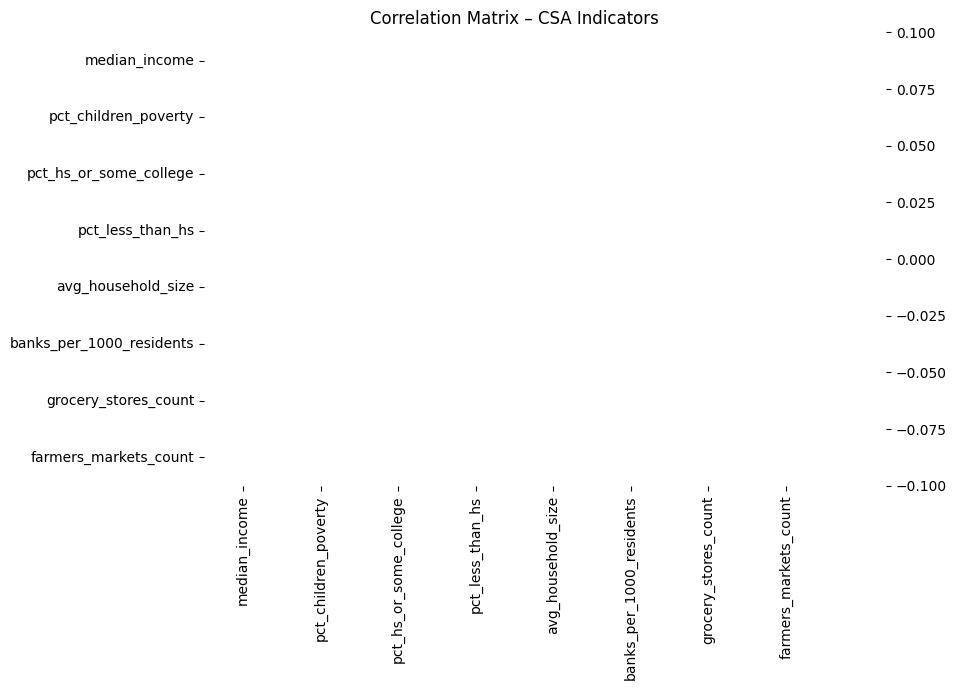

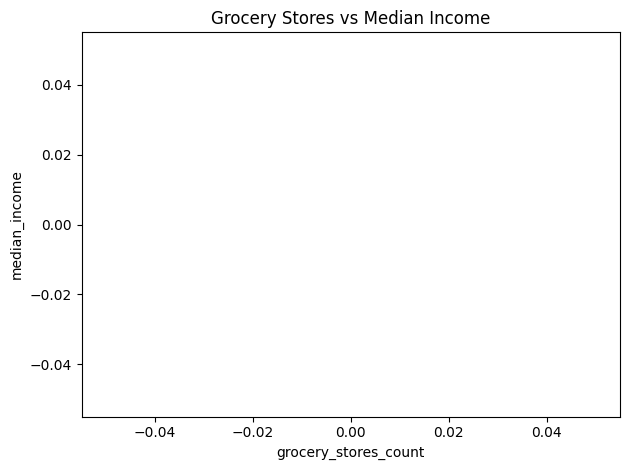

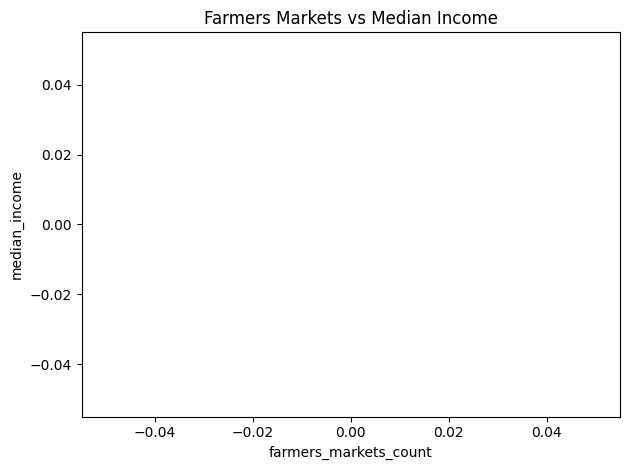

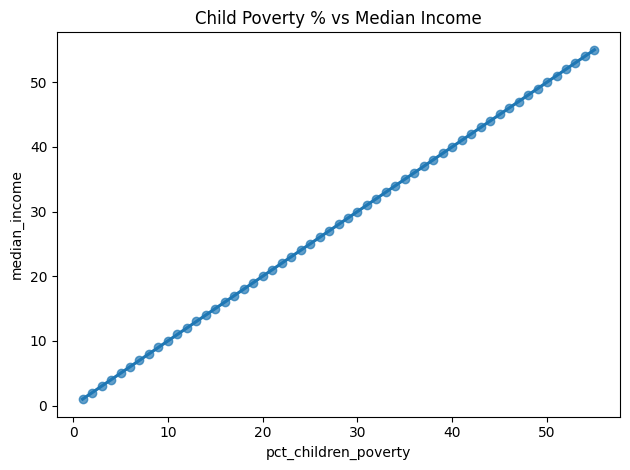

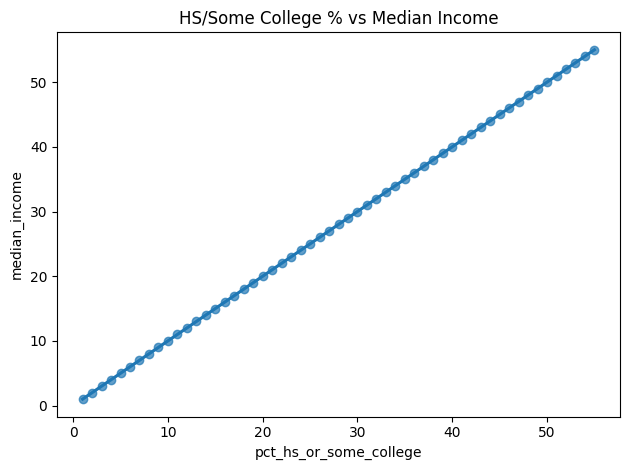

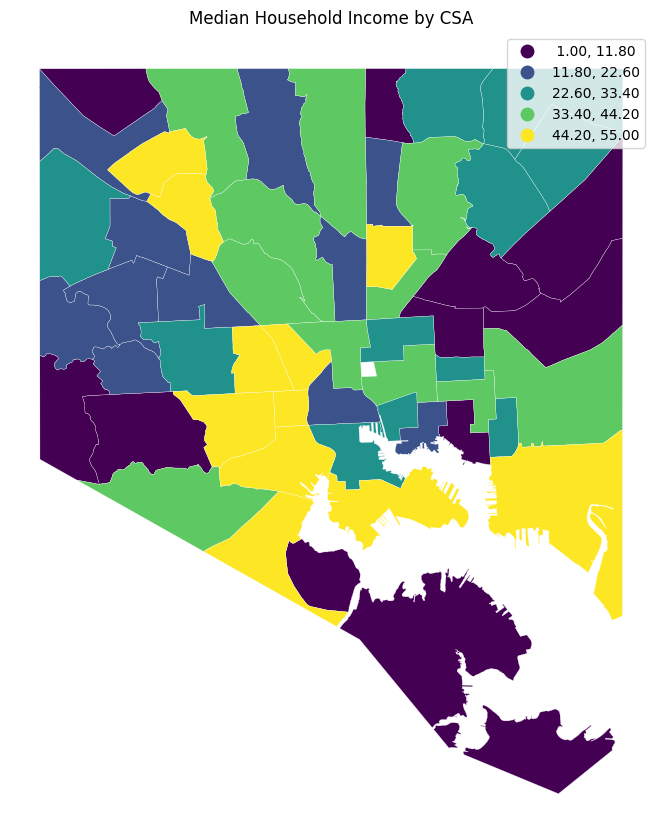

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/map_median_income.png


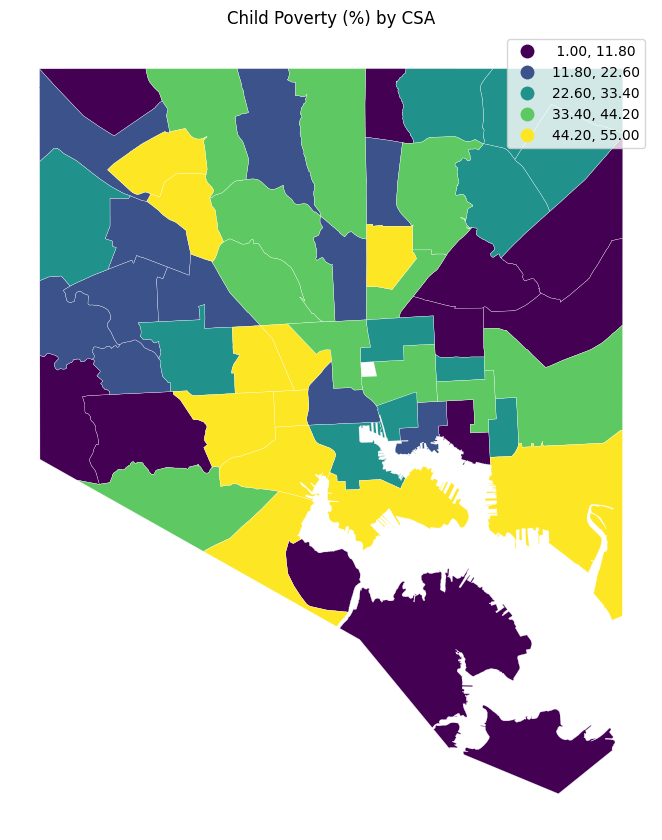

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/map_pct_children_poverty.png


/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/warrenjones/Dev/igs-analysis-baltimore/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


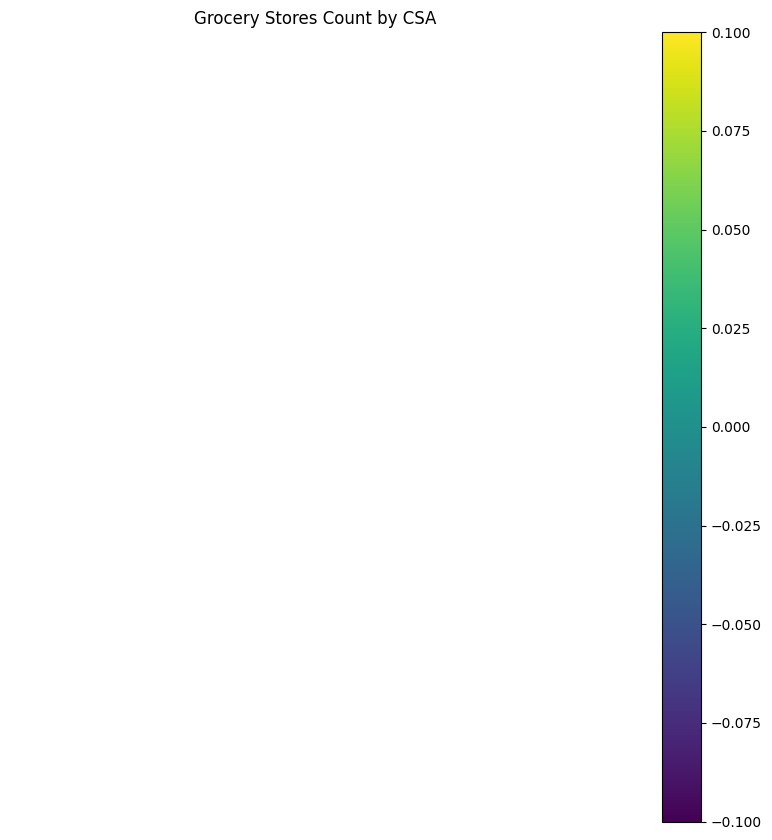

Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/map_grocery_stores_count.png
Dashboard complete. PNGs saved in: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals


In [19]:
# === COMMUNITY DASHBOARD (run this cell) ===
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Project root guard ---
try:
    ROOT
except NameError:
    ROOT = Path.cwd()
    if not (ROOT / "data_raw").exists() and (ROOT.parent / "data_raw").exists():
        ROOT = ROOT.parent

# --- Expect: `comm` (CSA dataframe with columns like 'csa', 'median_income', 'pct_children_poverty', etc.)
if "comm" not in globals():
    raise RuntimeError("`comm` DataFrame not found. Run the CSA build cells first.")

# --- Load CSA polygons (for maps) ---
def load_csas():
    csa_fp = ROOT / "data_raw" / "shapes" / "Community_Statistical_Areas_(CSAs)__Reference_Boundaries.geojson"
    csas = gpd.read_file(csa_fp)
    for c in ["CSA2010","csa2010","CSA","Community","COMMUNITY","Name","NAME","csa_name"]:
        if c in csas.columns:
            csas = csas.rename(columns={c:"csa"})
            break
    if "csa" not in csas.columns:
        raise KeyError(f"Could not find CSA name column in {csa_fp.name}. Columns: {csas.columns.tolist()}")
    if csas.crs is None:
        csas = csas.set_crs("EPSG:4326")
    return csas[["csa","geometry"]]

CSAS = load_csas()

# --- Output folder ---
outdir = ROOT / "visuals"
outdir.mkdir(exist_ok=True)

# ---------------------------
# 1) Correlation heatmap
# ---------------------------
num = comm.select_dtypes("number").dropna(how="any")
plt.figure(figsize=(10, 7))
sns.heatmap(num.corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Matrix – CSA Indicators")
plt.tight_layout()
plt.savefig(outdir / "csa_corr_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# 2) Key bivariate regressions
# ---------------------------
pairs = [
    ("grocery_stores_count", "median_income", "Grocery Stores vs Median Income"),
    ("farmers_markets_count", "median_income", "Farmers Markets vs Median Income"),
    ("pct_children_poverty", "median_income", "Child Poverty % vs Median Income"),
    ("pct_hs_or_some_college", "median_income", "HS/Some College % vs Median Income"),
]
for x, y, title in pairs:
    if x in comm.columns and y in comm.columns:
        ax = sns.regplot(data=comm, x=x, y=y, scatter_kws={"alpha":0.7})
        ax.set_title(title)
        plt.tight_layout()
        plt.savefig(outdir / f"reg_{x}_vs_{y}.png", dpi=300, bbox_inches="tight")
        plt.show()

# ---------------------------
# 3) CSA choropleths (3 examples)
# ---------------------------
csa_map = CSAS.merge(comm, on="csa", how="left")

def plot_choropleth(col, title):
    g = csa_map.copy()
    if col not in g.columns:
        print(f"Skip map: '{col}' not found.")
        return
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    try:
        g.plot(column=col, scheme="quantiles", k=5, cmap="viridis",
               legend=True, linewidth=0.2, edgecolor="white", ax=ax)
    except Exception:
        # Fallback without mapclassify
        vmin, vmax = g[col].quantile([0.05, 0.95])
        g.plot(column=col, cmap="viridis", legend=True,
               vmin=float(vmin), vmax=float(vmax),
               linewidth=0.2, edgecolor="white", ax=ax)
    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    out = outdir / f"map_{col}.png"
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved → {out}")

maps_to_make = [
    ("median_income", "Median Household Income by CSA"),
    ("pct_children_poverty", "Child Poverty (%) by CSA"),
    ("grocery_stores_count", "Grocery Stores Count by CSA"),
]
for col, title in maps_to_make:
    plot_choropleth(col, title)

print("Dashboard complete. PNGs saved in:", outdir)


In [20]:
# === CORRELATION SUMMARY (CSA relationships) ===
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

# Expect `comm` to exist (built earlier). Optionally, `comm2` may exist with extra cols (e.g., restaurants_total).
_df = comm.copy()
if "comm2" in globals():
    # merge any extra columns from comm2 (on 'csa') without clobbering
    extra_cols = [c for c in comm2.columns if c not in _df.columns or c == "csa"]
    _df = _df.merge(comm2[extra_cols], on="csa", how="left")

# Pick pairs to test (edit as you like)
pairs = [
    ("grocery_stores_count", "median_income"),
    ("farmers_markets_count", "median_income"),
    ("pct_children_poverty", "median_income"),
    ("pct_hs_or_some_college", "median_income"),
    ("banks_per_1000_residents", "median_income"),
    ("restaurants_total", "median_income"),   # will be skipped if not present
]

def pearson_ci(r, n, alpha=0.05):
    # Fisher z confidence interval for Pearson r
    if n is None or n < 4 or not np.isfinite(r) or abs(r) >= 1:
        return (np.nan, np.nan)
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)
    zcrit = stats.norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - zcrit * se)
    hi = np.tanh(z + zcrit * se)
    return (lo, hi)

rows = []
for x, y in pairs:
    if x not in _df.columns or y not in _df.columns:
        rows.append({"x": x, "y": y, "note": "skipped (missing column)"})
        continue

    # restrict to rows with both values
    sub = _df[[x, y]].apply(pd.to_numeric, errors="coerce").dropna()
    n = len(sub)
    if n < 4:
        rows.append({"x": x, "y": y, "n": n, "note": "skipped (n<4 after NA drop)"})
        continue

    r, p = stats.pearsonr(sub[x], sub[y])
    rho, ps = stats.spearmanr(sub[x], sub[y])
    lo, hi = pearson_ci(r, n)

    rows.append({
        "x": x,
        "y": y,
        "n": n,
        "pearson_r": round(float(r), 3),
        "pearson_p": float(p),
        "pearson_ci_lo": round(float(lo), 3) if np.isfinite(lo) else np.nan,
        "pearson_ci_hi": round(float(hi), 3) if np.isfinite(hi) else np.nan,
        "spearman_rho": round(float(rho), 3),
        "spearman_p": float(ps),
    })

summary = pd.DataFrame(rows)

# Order by strongest absolute Pearson r (where available), otherwise keep as-is
if "pearson_r" in summary.columns:
    summary = summary.sort_values(by="pearson_r", key=lambda s: s.abs(), ascending=False, na_position="last")

display(summary)

# Save to disk
outfp = ROOT / "data_clean" / "csa_correlations_summary.csv"
summary.to_csv(outfp, index=False)
print(f"Saved → {outfp}")


,x,y,n,note,pearson_r,pearson_p,pearson_ci_lo,pearson_ci_hi,spearman_rho,spearman_p
2,pct_children_poverty,median_income,55.0,NaN,1.0,0.0,1.0,1.0,1.0,0.0
3,pct_hs_or_some_college,median_income,55.0,NaN,1.0,0.0,1.0,1.0,1.0,0.0
4,banks_per_1000_residents,median_income,55.0,NaN,1.0,0.0,1.0,1.0,1.0,0.0
0,grocery_stores_count,median_income,0.0,skipped (n<4 after NA drop),NaN,NaN,NaN,NaN,NaN,NaN
1,farmers_markets_count,median_income,0.0,skipped (n<4 after NA drop),NaN,NaN,NaN,NaN,NaN,NaN
5,restaurants_total,median_income,NaN,skipped (missing column),NaN,NaN,NaN,NaN,NaN,NaN


Saved → /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean/csa_correlations_summary.csv
